In [12]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn opencv-python-headless >/dev/null 2>&1
!pip install gradio jinja2 >/dev/null 2>&1
!pip install wget >/dev/null 2>&1
!pip install kaggle >/dev/null 2>&1

print("Done")

Done


In [13]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import cv2
import re
import base64
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from io import BytesIO
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
import gradio as gr
import wget

In [14]:
# Function to load the dataset, extract comment text and labels, and return them along with the dataframe

def load_dataset(file_path='/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv'):
    try:
        df = pd.read_csv(file_path)
        X = df['comment_text']
        y = df[df.columns[2:]].values
        print("Dataset loaded successfully.")
    except FileNotFoundError:
        print(f"Dataset not found at '{file_path}'. Please place the 'train.csv' file in the same folder as the notebook.")
        raise
    return df, X, y

In [15]:
# Function to preprocess the data, vectorize comment text, and split it into train, validation, and test sets

def preprocess_data(df, X, max_features=200000, max_sequence_length=100, test_size=0.1, val_size=0.2):
    vectorizer = TextVectorization(max_tokens=max_features,
                                   output_sequence_length=max_sequence_length,
                                   output_mode='int')
    vectorizer.adapt(X.values)
    vectorized_text = vectorizer(X.values).numpy() 

    vocab = vectorizer.get_vocabulary()
    word_index = dict(zip(vocab, range(len(vocab))))
    max_sequence_length = max([len(x.split()) for x in X.values])

    y = df[df.columns[2:]].values
    print(f"Labels shape: {y.shape}")
    X_train, X_test, y_train, y_test = train_test_split(vectorized_text, y, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)

    train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16).cache().prefetch(8)
    val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16).cache().prefetch(8)
    test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16).cache().prefetch(8)

    return train, val, test, vectorizer, max_sequence_length

In [16]:
# Function to build, train, and evaluate the model, and save the model and training history

def build_and_train_model(train, val, test, max_features=200000, num_categories=6):
    model_filepath = 'toxicity.h5'

    if os.path.exists(model_filepath):
        print("Loading the existing model...")
        model = tf.keras.models.load_model(model_filepath)
        history = None
        batch_history = None
    else:
        print("Building and training a new model...")
        model = Sequential()

        model.add(Embedding(max_features + 1, 32))
        model.add(Bidirectional(LSTM(32, activation='tanh')))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(num_categories, activation='sigmoid'))

        model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy', Precision(), Recall()])
        model.summary()

        num_epochs = 5
        
         # Add early stopping callback
        early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

        # Create a callback to store the training history for each batch
        batch_history = {"loss": [], "accuracy": [], "epoch": []}

        # Create a variable to store the current epoch number
        current_epoch = [0]  # Use a list to make it mutable

        def on_batch_end(batch, logs):
            batch_history["loss"].append(logs["loss"])
            batch_history["accuracy"].append(logs["accuracy"])
            batch_history["epoch"].append(current_epoch[0])  # Store the current epoch number

        def on_epoch_begin(epoch, logs):
            current_epoch[0] = epoch

        batch_end_callback = tf.keras.callbacks.LambdaCallback(on_batch_end=on_batch_end)
        epoch_begin_callback = tf.keras.callbacks.LambdaCallback(on_epoch_begin=on_epoch_begin)

        history = model.fit(train, epochs=num_epochs, validation_data=val, callbacks=[batch_end_callback, epoch_begin_callback, early_stopping_callback])

        model.save(model_filepath)
        
    # Evaluate the model on the test set
    try:
        test_metrics = model.evaluate(test)
    except ValueError as e:
        print(f"Model output shape: {model.output_shape}")
        raise ValueError("Error occurred during model evaluation.") from e

    return model, history, test_metrics, batch_history

In [17]:
# Function to highlight toxic words in a comment based on the model's predictions and custom categories

def highlight_toxic_words(comment, results, threshold=0.5, custom_categories=None):
    categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    category_color = '#FF9999'  # red

    if custom_categories is None:
        custom_categories = {'spam': [], 'fraud': [], 'sexual': []}

    custom_colors = {
        'spam': '#800080',  # purple
        'fraud': '#FFA500',  # orange
        'sexual': '#008000'  # green
    }

    toxic_categories = [categories[i] for i, r in enumerate(results) if r >= threshold]
    words = comment.split()
    highlighted_words = []

    for word in words:
        if any(category in toxic_categories for category in categories):
            highlighted_words.append(f"<span style='background-color: {category_color}'>{word}</span>")
        else:
            highlighted_words.append(word)

    highlighted_comment = " ".join(highlighted_words)

    for category, words in custom_categories.items():
        color = custom_colors[category]
        for word in words:
            highlighted_comment = highlighted_comment.replace(word, f"<span style='background-color: {color}'>{word}</span>")

    return highlighted_comment

In [18]:
# Function to score a comment for toxicity using the model and highlight toxic words

def score_comment(comment, model, vectorizer, max_sequence_length, threshold=0.5, custom_categories=None):
    if custom_categories is None:
        custom_categories = {'spam': [], 'fraud': [], 'sexual': []}

    # Split the input text into sentences
    sentences = re.split('[.!?]', comment)
    highlighted_sentences = []

    for sentence in sentences:
        if sentence.strip():
            vectorized_sentence = vectorizer([sentence])
            X = vectorized_sentence

            results = model.predict(X)[-1]
            highlighted_sentence = highlight_toxic_words(sentence, results, threshold, custom_categories)
            highlighted_sentences.append(highlighted_sentence)

    # Concatenate the highlighted sentences
    highlighted_comment = ' '.join(highlighted_sentences)
    return highlighted_comment

In [19]:
# Function to get custom categories and their corresponding words or phrases from the user

def get_custom_categories():
    custom_categories = {'spam': [], 'fraud': [], 'sexual': []}

    for category in custom_categories.keys():
        print(f"Enter words or phrases for {category} category (separated by commas):")
        user_input = input().strip()
        if user_input:
            custom_categories[category] = [word.strip() for word in user_input.split(',')]

    return custom_categories

In [20]:
# Function to create a Gradio interface for scoring comments using the model

def create_gradio_interface(model, vectorizer, max_sequence_length):
    interface = gr.Interface(
        fn=lambda comment: score_comment(comment, model, vectorizer, max_sequence_length),
        inputs=[
            gr.inputs.Textbox(lines=2, placeholder='Comment to score')
        ],
        outputs=gr.outputs.HTML()
    )
    return interface

In [21]:
# Function to plot the training loss and accuracy for each epoch

def plot_training_evaluation(batch_history):
    epochs = np.array(batch_history["epoch"]) + 1
    plt.figure(figsize=(12, 6))

    for epoch in range(1, 4):
        epoch_indices = epochs == epoch
        plt.plot(np.array(batch_history["loss"])[epoch_indices], label=f"Training Loss - Epoch {epoch}")
        plt.plot(np.array(batch_history["accuracy"])[epoch_indices], label=f"Training Accuracy - Epoch {epoch}")

    plt.xlabel("Batch")
    plt.ylabel("Loss / Accuracy")
    plt.title("Training Loss and Accuracy")
    plt.legend()
    plt.show()

Dataset loaded successfully.
Labels shape: (159571, 6)
Building and training a new model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)            

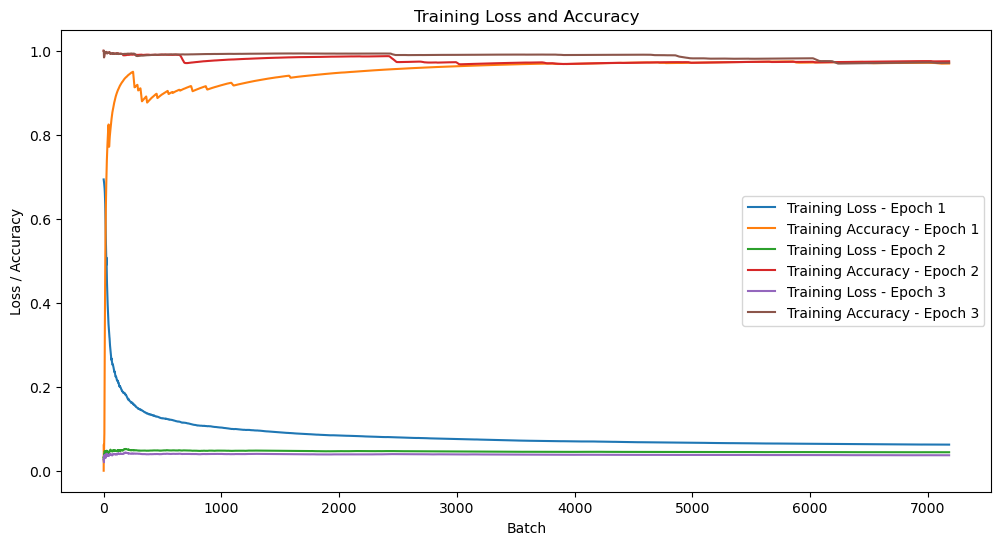

Enter words or phrases for spam category (separated by commas):


 111, 222, 333


Enter words or phrases for fraud category (separated by commas):


 aaa, bbb, ccc


Enter words or phrases for sexual category (separated by commas):


 !!!, @@@, ###


Test metrics:
Loss: 0.0496
Accuracy: 0.9940
Precision_1: 0.7909
Recall_1: 0.6897


/opt/conda/lib/python3.7/site-packages/gradio/inputs.py:28: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/opt/conda/lib/python3.7/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/opt/conda/lib/python3.7/site-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://226dc924ffd373b5df.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 33ms/step


In [22]:
# Main script to load and preprocess data, build and train the model, plot evaluation, and launch Gradio interface

if __name__ == "__main__":
    df, X, y = load_dataset()
    train, val, test, vectorizer, max_sequence_length = preprocess_data(df, X)
    model, history, test_metrics, batch_history = build_and_train_model(train, val, test)

    if batch_history is not None:
        plot_training_evaluation(batch_history)

    custom_categories = get_custom_categories()
    
    print("Test metrics:")
    for metric_name, metric_value in zip(model.metrics_names, test_metrics):
        print(f"{metric_name.capitalize()}: {metric_value:.4f}")
    
    interface = gr.Interface(
        fn=lambda comment: score_comment(comment, model, vectorizer, max_sequence_length, custom_categories=custom_categories),
        inputs=[
            gr.inputs.Textbox(lines=2, placeholder='Comment to score')
        ],
        outputs=gr.outputs.HTML()
    )
    interface.launch(share=True)